In [36]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
drive.mount('/content/drive')
labels = '/content/drive/MyDrive/kaggle'

#dataset stored in kaggle
#data set link : https://drive.google.com/drive/folders/1y9Hni5vaNe-eeGxqpbmKFxjzSSU0gtv2?usp=drive_link
#extra data set used :  https://drive.google.com/drive/folders/1BcrNuXUHuhWFbn-CCcGDzm-ua9Klp7JP?usp=drive_link


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:

def crop_eye(image_path):

    image = cv2.imread(image_path)

    if image is None:
        print("Failed to load the image.")
        return None

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(eyes) > 0:
        (x, y, w, h) = eyes[0]
        cropped_eye = image[y:y+h, x:x+w]


        resized_eye = cv2.resize(cropped_eye, (145, 145))

        return resized_eye

    return None


In [37]:

def load_and_resize_eye_data(dir_path, target_size=(145, 145)):
    labels = ['Closed', 'Open']
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                image = cv2.imread(img_path)
                if image is not None:

                    resized_image = cv2.resize(image, target_size)
                    data.append([resized_image, class_num])
            except Exception as e:
                print(e)
    return data

data = load_and_resize_eye_data("/content/drive/MyDrive/kaggle/train/")

X = [image for image, _ in data]
y = [label for _, label in data]


X = np.array(X)
y = np.array(y)


In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

APPENDING DATA TO ARRAY

In [8]:
model = Sequential()
model.add(Conv2D(256, (3, 3), activation='relu', input_shape=(145, 145, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [28]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 71, 71, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30
)
test_datagen = ImageDataGenerator(rescale=1/255)

In [11]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=test_datagen.flow(X_test, y_test),
    shuffle=True,
    validation_steps=len(X_test) // 32
)

Epoch 1/50
32/32 [==============================] - 20s 284ms/step - loss: 0.6886 - accuracy: 0.5945 - val_loss: 0.5836 - val_accuracy: 0.8005
Epoch 2/50
32/32 [==============================] - 8s 253ms/step - loss: 0.3868 - accuracy: 0.8356 - val_loss: 0.4061 - val_accuracy: 0.8438
Epoch 3/50
32/32 [==============================] - 7s 211ms/step - loss: 0.2177 - accuracy: 0.9213 - val_loss: 0.1192 - val_accuracy: 0.9519
Epoch 4/50
32/32 [==============================] - 7s 208ms/step - loss: 0.1562 - accuracy: 0.9419 - val_loss: 0.1048 - val_accuracy: 0.9519
Epoch 5/50
32/32 [==============================] - 9s 266ms/step - loss: 0.1372 - accuracy: 0.9488 - val_loss: 0.1234 - val_accuracy: 0.9615
Epoch 6/50
32/32 [==============================] - 7s 210ms/step - loss: 0.1822 - accuracy: 0.9331 - val_loss: 0.1869 - val_accuracy: 0.9327
Epoch 7/50
32/32 [==============================] - 9s 270ms/step - loss: 0.1614 - accuracy: 0.9419 - val_loss: 0.1132 - val_accuracy: 0.9591
Epoch

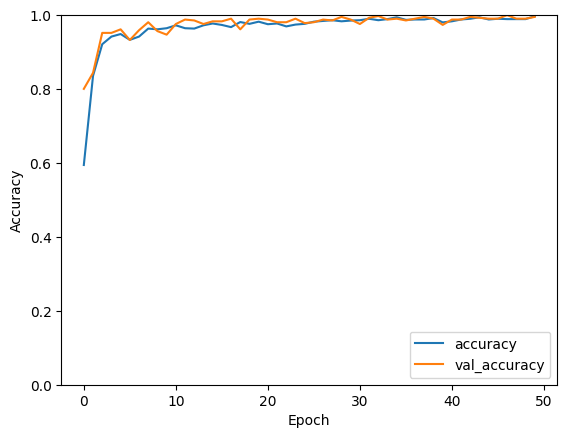

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [13]:
model.save("drowiness_new6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:

def prepare_image(filepath):
    cropped_eye = crop_eye(filepath)
    if cropped_eye is not None:
        resized_eye = cv2.resize(cropped_eye, (145, 145))
        normalized_eye = resized_eye / 255.0
        return normalized_eye.reshape(-1, 145, 145, 3)
    else:
        return None


model = tf.keras.models.load_model("drowiness_new6.h5")


def p(image_path):

  input_data = prepare_image(image_path)

  if input_data is not None:

    prediction = model.predict(input_data)
    print("Prediction:", prediction)
    if prediction > 0.5:
        print("Eye state: Open")
    else:
        print("Eye state: Closed")
  else:
    print("No eye detected in the image.")

p("/content/drive/MyDrive/xx/no_yawn/1008.jpg")

1/1 [==============================] - 0s 105ms/step
Prediction: [[0.9110272]]
Eye state: Open


In [ ]:
folder_path = "/content/drive/MyDrive/kaggle/train/Open"

def resize_image(image_path, target_size=(145, 145)):
    image = cv2.imread(image_path)
    if image is not None:
        resized_image = cv2.resize(image, target_size)
        normalized_image = resized_image / 255.0
        return normalized_image.reshape(-1, *target_size, 3)
    else:
        return None

true_labels = {}

correct_predictions = 0
total_predictions = 0

for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(folder_path, filename)
        input_data = resize_image(image_path)
        if input_data is not None:
            prediction = model.predict(input_data)
            predicted_label = 1 if prediction > 0.5 else 0
            if filename in true_labels:
                true_label = true_labels[filename]
                if true_label == predicted_label:
                    correct_predictions += 1
                total_predictions += 1
            else:
                print(f"Prediction for {filename}: {'Open' if predicted_label == 1 else 'Closed'}")
                total_predictions += 1

if total_predictions > 0:
    accuracy = correct_predictions / total_predictions
    print(f"Accuracy: {accuracy * 100:.2f}% ({correct_predictions}/{total_predictions})")
else:
    print("Prediction completed for all images.")


In [43]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg
1/1 [==============================] - 0s 54ms/step
Prediction: [[0.0001396]]
Eye state: Closed


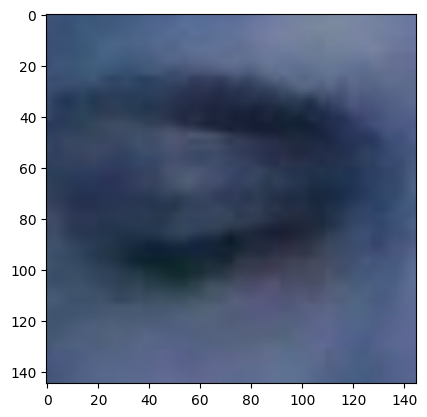

In [46]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  #display(Image(filename))
except Exception as err:

  print(str(err))

p("photo.jpg")

c=crop_eye("photo.jpg")
plt.imshow((c))

<IPython.core.display.Javascript object>

Saved to photo.jpg
1/1 [==============================] - 0s 22ms/step
Prediction: [[0.79911584]]
Eye state: Open


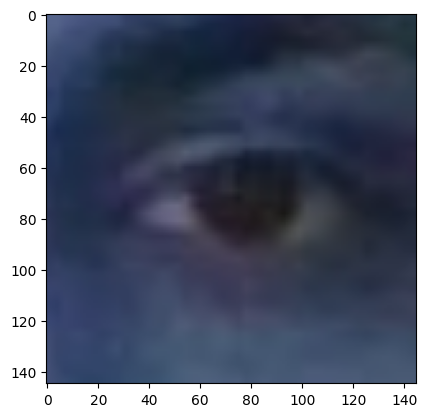

In [47]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  #display(Image(filename))
except Exception as err:

  print(str(err))

p("photo.jpg")

c=crop_eye("photo.jpg")
plt.imshow((c))

In [56]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

def js_to_image(js_reply):
  image_bytes = b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv2.imdecode(jpg_as_np, flags=1)
  return img

def bbox_to_bytes(bbox_array):
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  bbox_PIL.save(iobuf, format='png')
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
  return bbox_bytes


In [57]:
def take_photo(filename='photo.jpg', quality=0.9):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  data = eval_js('takePhoto({})'.format(quality))
  img = js_to_image(data)
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  faces = face_cascade.detectMultiScale(gray)
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  cv2.imwrite(filename, img)

  return filename


In [58]:

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640;
      captureCanvas.height = 480;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [51]:
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

ESP32 connection through Blynk IOT

In [62]:
import requests
import smtplib
from email.mime.text import MIMEText

def mail():
    email="abc@gmail.com"
    rec="abc@gmail.com"

    subject="alert"
    msg="driver is sleeping emergency"
    txt=f"subject:{subject}\n\n{msg}"
    server=smtplib.SMTP("smtp.gmail.com",587)
    server.starttls()
    server.login(email,"keyhere")
    server.sendmail(email,rec,txt)
    print("done")

def iot(get_data_endpoint):
  try:
      # Send GET request to the endpoint to update v0 to 1
      response = requests.get(get_data_endpoint)

      # Check if request was successful (status code 200)
      if response.status_code == 200:
          print("iot successfully.")
      else:
          print("iot failed")

  except requests.RequestException as e:
      print("An error occurred:", e)



REAL TIME FRAME ANALYSIS using Webcam

In [63]:
import cv2
import time
import numpy as np
from keras.models import load_model
import json

# Load your pre-trained model
model = tf.keras.models.load_model("drowiness_new6.h5")

def prepare_image_for_prediction(image):
    width, height = 145, 145
    prepared_image = cv2.resize(image, (width, height))
    prepared_image = prepared_image / 255.0
    return np.expand_dims(prepared_image, axis=0)

def crop_eye0(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(eyes) > 0:
        (x, y, w, h) = eyes[0]
        cropped_eye = image[y:y+h, x:x+w]
        resized_eye = cv2.resize(cropped_eye, (145, 145))
        return resized_eye
    return None

def prepare_image(image):
    cropped_eye = crop_eye0(image)
    if cropped_eye is not None:
        resized_eye = cv2.resize(cropped_eye, (145, 145))
        normalized_eye = resized_eye / 255.0
        return normalized_eye.reshape(-1, 145, 145, 3)
    else:
        return None

def pr(input_data, count):
    if input_data is not None:
        prediction = model.predict(input_data)
        print("Prediction:", prediction)
        if prediction > 0.5:
            v0 = f'https://blr1.blynk.cloud/external/api/update?token=J0BpK_Y7m9_tfYmy4hqAfaPN03gcjr7Y&v0=0'
            iot(v0)
            print("Eye state: Open")
            if count > 0:
                count = 0
        else:
            print("Eye state: Closed")
            v0 = f'https://blr1.blynk.cloud/external/api/update?token=J0BpK_Y7m9_tfYmy4hqAfaPN03gcjr7Y&v0=1'
            iot(v0)
            count += 1
    else:
        print("No eye detected in the image.")
    return count

video_stream()
label_html = 'Capturing...'
bbox = ''
count = 0
sent = False

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    img = js_to_image(js_reply["img"])
    prepared_image = prepare_image(img)
    count = pr(prepared_image, count)
    if count > 10:
        if sent == False:
            mail()
            sent = True
            v1 = f'https://blr1.blynk.cloud/external/api/update?token=J0BpK_Y7m9_tfYmy4hqAfaPN03gcjr7Y&v1=1'
            iot(v1)
    bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    for (x, y, w, h) in faces:
        bbox_array = cv2.rectangle(bbox_array, (x, y), (x + w, y + h), (255, 0, 0), 2)
    bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes
    time.sleep(0.5)


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 87ms/step
Prediction: [[0.99570316]]
iot successfully.
Eye state: Open
1/1 [==============================] - 0s 28ms/step
Prediction: [[0.97440606]]
iot successfully.
Eye state: Open
1/1 [==============================] - 0s 20ms/step
Prediction: [[0.9934815]]
iot successfully.
Eye state: Open
1/1 [==============================] - 0s 19ms/step
Prediction: [[0.97051775]]
iot successfully.
Eye state: Open
1/1 [==============================] - 0s 21ms/step
Prediction: [[0.47529873]]
Eye state: Closed
iot successfully.
1/1 [==============================] - 0s 20ms/step
Prediction: [[0.00038938]]
Eye state: Closed
iot successfully.
1/1 [==============================] - 0s 29ms/step
Prediction: [[0.76570547]]
iot successfully.
Eye state: Open
1/1 [==============================] - 0s 22ms/step
Prediction: [[0.00038993]]
Eye state: Closed
iot successfully.
1/1 [==============================] - 0s 21ms/step
Prediction: [[0.03139205]]
Eye state: C